In [ ]:
# !pip install fastapi

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from configs import *
warnings.filterwarnings('ignore')
%matplotlib inline


## Train Logstic Model Using Sklearn

In [2]:
def fit_predict_print_f1_score(model, model_name, X_train, y_train):
    
    model.fit(X_train, y_train)  
    predicted              = model.predict(X_train)
    f1_scr                 = f1_score(y_train, predicted)
    print("f1 score on traning with classifer: " + model_name + str(f1_scr))
    print("="*50)
    return model

In [3]:
def grid_search_logistic_regression_ridge_l2_norm(parameters, X_train, y_train):
    '''
    The function used to search for best parameter that we can use with Ridge Regression L2,
    to used later for LogisticRegression model with L2 regularization only,
    and related hyper paramter can be used with Ridge Regression L2.
    '''
    
     # First search for best parameter
    log_reg_clf                            = SGDClassifier(penalty="l2",  learning_rate='optimal',
                                                           early_stopping=True, n_jobs=-1)
    grd_serch                              = GridSearchCV(log_reg_clf, parameters, cv=3)
    grd_serch.fit(X_train, y_train)
    
    print("Score: ====================")
    print(grd_serch.best_score_)
    
    print("Best Params: ====================")
    print(grd_serch.best_params_)
    print("="*50)
    
    max_iter_                              = grd_serch.best_params_['max_iter']
    alpha_                                 = grd_serch.best_params_['alpha']
#     learning_rate_                         = grd_serch.best_params_['learning_rate']
    best_params_str = str(grd_serch.best_params_) + "_"
    # Create instance of Ridge Regression L2 with best parameter we have found
    trained_sgd_reg_ridge_l2_norm_clf = SGDClassifier(penalty="l2", early_stopping=True, 
                                                           max_iter=max_iter_, alpha=alpha_, 
                                                           learning_rate='optimal', n_jobs=-1)
    
    return trained_sgd_reg_ridge_l2_norm_clf, best_params_str

In [4]:
def train_logistic_classifier(parameters, img_size, X_train, y_train):
    '''
    The function used to train different logistic classifier based on the Regularization Term (norm_type)
    '''
    
    # For Ridge Regression
    # Search for best parameters with L2 Regression and return LogisticRegression object with these best param
    trained_sgd_reg_ridge_l2_norm_clf, best_params_str = grid_search_logistic_regression_ridge_l2_norm(parameters,
                                                                  X_train, y_train)

    # The function used to fit any model send to it, then get f1_score and print using this trained model
    model_name =  "SGD Ridge Regression L2 Norm classifier_" + img_size + best_params_str
    trained_sgd_reg_ridge_l2_norm_clf = fit_predict_print_f1_score(trained_sgd_reg_ridge_l2_norm_clf, model_name,
                                                                  X_train, y_train)
        
    return trained_sgd_reg_ridge_l2_norm_clf, model_name
    


# Train

100
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


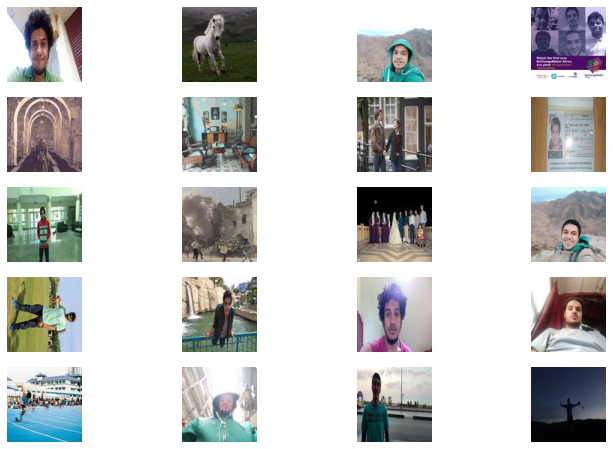

In [5]:
df_all_images = images_pipeline(100, "_100_100_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train)

In [6]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(1000, 3000, 5).astype(int)), 
                                            'alpha'    : list(np.linspace(.01, 1 , 10).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_100_100_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.65
Best Params: ====================
{'alpha': 1.0, 'max_iter': 3000}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_100_100_3{'alpha': 1.0, 'max_iter': 3000}_0.7102803738317757
f1 score on validation with classifer: 0.6474820143884892


300
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 270000)
(97, 270000)
(1, 600)
(1, 97)
===================After===================
(270000, 600)
(270000, 97)
(1, 600)
(1, 97)


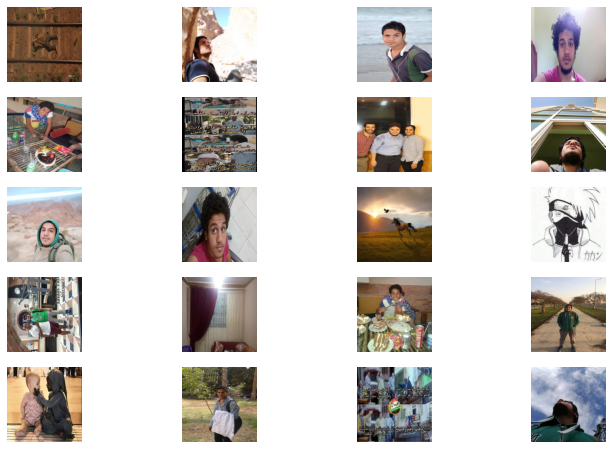

In [7]:
df_all_images = images_pipeline(300, "_300_300_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 300)

In [8]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(1000, 3000, 5).astype(int)), 
                                            'alpha'    : list(np.linspace(.01, 1 , 10).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_300_300_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.6733333333333333
Best Params: ====================
{'alpha': 1.0, 'max_iter': 2500}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_300_300_3{'alpha': 1.0, 'max_iter': 2500}_0.7614080834419816
f1 score on validation with classifer: 0.7746478873239437


500
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 750000)
(97, 750000)
(1, 600)
(1, 97)
===================After===================
(750000, 600)
(750000, 97)
(1, 600)
(1, 97)


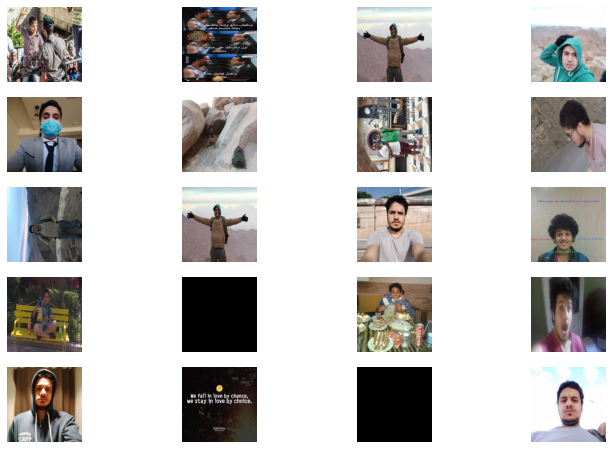

In [9]:
df_all_images = images_pipeline(500, "_500_500_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 500)

In [10]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(1000, 3000, 5).astype(int)), 
                                            'alpha'    : list(np.linspace(.01, 1 , 10).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_500_500_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.645
Best Params: ====================
{'alpha': 0.01, 'max_iter': 2500}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_500_500_3{'alpha': 0.01, 'max_iter': 2500}_0.8906009244992297
f1 score on validation with classifer: 0.7037037037037038


100
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


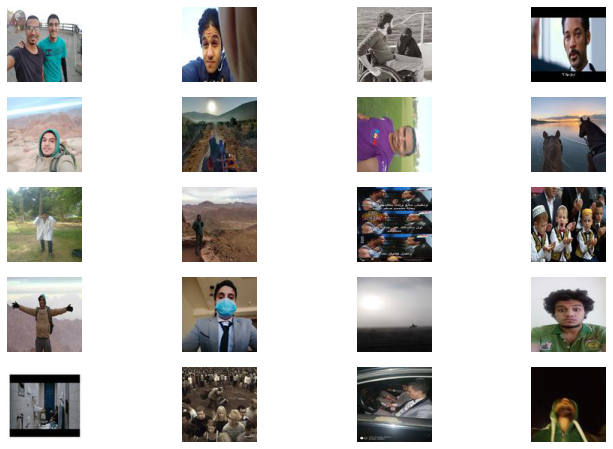

In [11]:
df_all_images = images_pipeline(100, "_100_100_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 100)

In [12]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(2000, 5000, 10).astype(int)), 
                                            'alpha'    : list(np.linspace(.1, 3 , 15).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_100_100_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.6649999999999999
Best Params: ====================
{'alpha': 3.0, 'max_iter': 2000}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_100_100_3{'alpha': 3.0, 'max_iter': 2000}_0.7817896389324961
f1 score on validation with classifer: 0.616822429906542


300
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 270000)
(97, 270000)
(1, 600)
(1, 97)
===================After===================
(270000, 600)
(270000, 97)
(1, 600)
(1, 97)


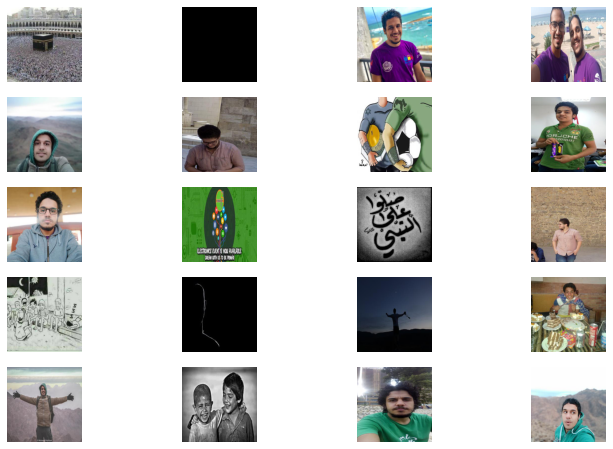

In [13]:
df_all_images = images_pipeline(300, "_300_300_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 300)

In [14]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(2000, 5000, 10).astype(int)), 
                                            'alpha'    : list(np.linspace(.1, 3 , 15).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_300_300_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.6716666666666667
Best Params: ====================
{'alpha': 0.30714285714285716, 'max_iter': 2000}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_300_300_3{'alpha': 0.30714285714285716, 'max_iter': 2000}_0.8249566724436741
f1 score on validation with classifer: 0.5591397849462364


500
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 750000)
(97, 750000)
(1, 600)
(1, 97)
===================After===================
(750000, 600)
(750000, 97)
(1, 600)
(1, 97)


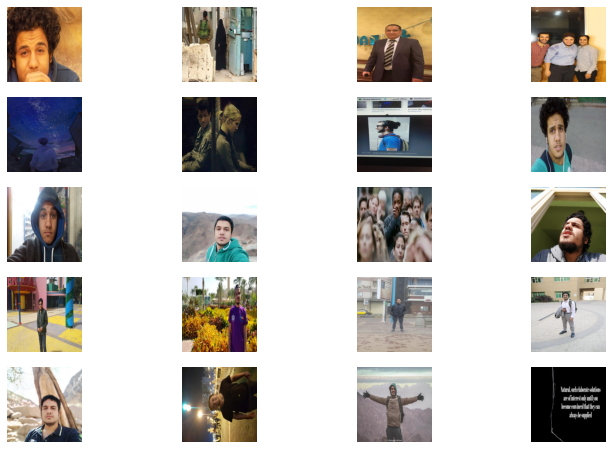

In [15]:
df_all_images = images_pipeline(500, "_500_500_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 500)

In [16]:
X_train, X_val,y_train, y_val        = X_train.T, X_val.T, y_train.T, y_val.T

# Paramter for logistic regression l2 norm
sgd_reg_ridge_l2_norm_parameters     = {    'max_iter': list(np.linspace(2000, 5000, 10).astype(int)), 
                                            'alpha'    : list(np.linspace(.1, 3 , 15).astype(float)),
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_sgd_reg_ridge_l2_norm_clf, model_name    = train_logistic_classifier(sgd_reg_ridge_l2_norm_parameters, 
                                        "img_size_500_500_3", X_train, y_train)


# Validate 
predicted                            = trained_sgd_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                               = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

# Save logistic Model
filename = model_name + "validation f1_scor_" + str(f1_scr) + '_.sav'
pickle.dump(trained_sgd_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

Score: ====================
0.6666666666666666
Best Params: ====================
{'alpha': 2.585714285714286, 'max_iter': 2666}
f1 score on traning with classifer: SGD Ridge Regression L2 Norm classifier_img_size_500_500_3{'alpha': 2.585714285714286, 'max_iter': 2666}_0.8114901256732495
f1 score on validation with classifer: 0.6595744680851064
